In [44]:
# FINAL FORM FOR NERVE NET ARCH

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import scipy.sparse as sp

Input I need:
1. The graph (cora is undirected so I will just make each edge a 2-way) in networkx
2. predecessors list since this is a static graph and i need it for the aggregate
3. N x h that is updated every prop because its a static graph so this is faster

In [46]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

def load_dataset(path='../data/cora/', dataset='cora'):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features.todense(), adj.todense(), labels

In [47]:
# X: N x f
# A: N x N
# y: N x c
X, A, y = load_dataset()

Loading cora dataset...
Dataset has 2708 nodes, 5429 edges, 1433 features.


In [48]:
G = nx.from_numpy_matrix(A).to_directed()
# Convert targets to a vector with the index value
y = np.argmax(y, axis=1)
# Convert y into a tensor
y = torch.tensor(y)

In [49]:
N = X.shape[0]  # Num nodes
f = X.shape[1]  # Num input feats
h = 256  # Hidden state for node size
m = 64  # Message size
num_class = 7
o = num_class  # Output size
range_train = [0, 140]
range_val = [200, 500]
range_test = [500, 1500]

In [50]:
# This is the only thing i use the graph for
predecessors = []
for node in G.nodes:
    predecessors.append(list(G.predecessors(node)))
assert len(predecessors) == N

In [51]:
# This is so the hidden size doesnt need to be the same size as the feature size
# Input: (N, f)
# Output: (N, h)
class InputModel(nn.Module):
    def __init__(self):
        super(InputModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(f, h),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, nodes):
        assert nodes.shape == (N, f)
        hidden_states = self.model(nodes)
        assert hidden_states.shape == (N, h)
        return hidden_states

In [52]:
# Input: (N, h) which is all nodes hidden states
# Outut: (N, m) all nodes messages
class MessageModel(nn.Module):
    def __init__(self):
        super(MessageModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(h, m),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, nodes):
        assert nodes.shape == (N, h)
        messages = self.model(nodes)
        assert messages.shape == (N, m)
        return messages

In [53]:
# Input: (N, m + h) agg messages and hidden states
# Output: (N, h) new hidden states for nodes
class UpdateModel(nn.Module):
    def __init__(self):
        super(UpdateModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(m + h, h),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
    def forward(self, messages, hidden_states):
        assert messages.shape == (N, m)
        assert hidden_states.shape == (N, h)
        # Concat
        concat = torch.cat([messages, hidden_states], dim=1)
        assert concat.shape == (N, m + h)
        updates = self.model(concat)
        assert updates.shape == (N, h)
        return updates

In [54]:
# Input: (N, h)  updated node hidden states
# Output: (N, o)  outputs for each node (softmax on classes)
class OutputModel(nn.Module):
    def __init__(self):
        super(OutputModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(h, o)
        )
        
    def forward(self, nodes):
        assert nodes.shape == (N, h)
        outputs = self.model(nodes)
        assert outputs.shape == (N, o)
        return outputs

In [55]:
def plot_grad_flow(layers, ave_grads, max_grads):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems. '''

#     plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
#     plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
#     plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
#     plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
#     plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
#     plt.xlabel("Layers")
#     plt.ylabel("average gradient")
#     plt.title("Gradient flow")
#     plt.grid(True)
#     plt.legend([Line2D([0], [0], color="c", lw=4),
#                 Line2D([0], [0], color="b", lw=4),
#                 Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    
#     plt.show()

In [59]:
# Graph NN block
class GNBlock(nn.Module):
    def __init__(self):
        super(GNBlock, self).__init__()
        self.input_model = InputModel()
        self.message_model = MessageModel()
        self.update_model = UpdateModel()
        self.output_model = OutputModel()
        
        self.loss = nn.CrossEntropyLoss()
    
    # Input: (N x m)
    # Output: (N x m)
    def aggregate(self, predecessors, messages):
        agg = []
        # Collect all in predecessors for each node, if a node has no preds then just 0s for it
        for preds in predecessors:
            if len(preds) > 0:
                in_mess = messages[preds, :]
                assert in_mess.shape == (len(preds), m) or in_mess.shape == (m,)  # if one in-node
#                 agg_in_mess = agg_func(in_mess)
                agg_in_mess = torch.sum(in_mess, dim=0)
                assert agg_in_mess.shape == (m,)
                agg.append(agg_in_mess)
            else:
                agg.append(torch.zeros(m))
        # Stack
#         stack = np.stack(agg)
        stack = torch.stack(agg)
        assert stack.shape == (N, m)
        return stack
        
    # Propogate (THIS ASSUMES THAT THE INITIAL FEATURES ARE SENT IN ON EVERY FIRST PROP OF AN EPOCH)
    def forward(self, inputs, send_input, get_output):
        # Get initial hidden states ------
        if send_input:
            node_states = self.input_model(inputs)
        else:
            node_states = inputs
        # Get messages of each node ----
        messages = self.message_model(node_states)
        # Aggregate pred. edges -----
        aggregates = self.aggregate(predecessors, messages)
        # Get Updates for each node hidden state ---------
        updates = self.update_model(aggregates, node_states)
        # Get outputs if need to ------
        if get_output:
            outputs = self.output_model(updates)
            return updates, outputs
        return updates, None
    
    # Outputs: (N_train, o) tensor
    # Targets: (N_train,) tensor of the classes
    def backward(self, outputs, targets):
        num_train = range_train[1] - range_train[0]
        assert outputs.shape == (num_train, o)
        assert targets.shape == (num_train,)
        loss = self.loss(outputs, targets)
        loss.backward()
        # Graph gradient flow
        self.graph_grads()
        
        # Print grad
#         for n, p in self.input_model.named_parameters():
#             print(p.abs().mean())
        
        return loss.data.tolist()
    
    # Given model get grads
    def get_layer_grads(self, model):
        layers, avg_grads, max_grads = [], [], []
        for n, p in model.named_parameters():
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                avg_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
        return layers, avg_grads, max_grads
    
    def graph_grads(self):
        layers = []
        avg_grads = []
        max_grads = []
        
        for model in [self.input_model, self.message_model, self.update_model, self.output_model]:
            l, a, m = self.get_layer_grads(model)
            layers.extend(l)
            avg_grads.extend(a)
            max_grads.extend(m)
        
        plot_grad_flow(layers, avg_grads, max_grads)
        
    # Just gets the loss for a set (doesnt optimize)
    def get_loss(self, outputs, targets):
        assert outputs.shape[0] == targets.shape[0]
        loss = self.loss(outputs, targets)
        return loss.data.tolist()
    
    def get_accuracy(self, outputs, targets):
        assert outputs.shape[0] == targets.shape[0]
        outputs_ = np.array(outputs.data.tolist())
        output_preds = np.argmax(outputs_, axis=1)
        targets = np.array(targets.data.tolist())
        acc = ((output_preds == targets).sum()) / targets.shape[0]
        return acc
        

In [60]:
# One major difference is that GCN does not change the features of the nodes, this arch does because it has
# hidden states. I'm gonna definitly wanna consider/try NOT changing the nodes hidden states between outputs.
# Meaning, they can change in propgations, but after the prop loop is done (outputs/actions have been recieved)
# I reset the node states and edge states. Which really just means like in the GCN model I input the features
# for every round to refresh them. 

# IMPORTANT: Actually this does do that, because the node feats (X) are sent in every epoch

# Also note that one prop can be considered like a layer of a GCN
def run_epoch(gnn, opimizer, X, num_props, epoch_num):
    # Every time you run through a minibatch, zero out the grad
    optimizer.zero_grad()
    # Convert node_feats np to node_states torch tensor
    node_states = torch.tensor(X).float()
    for p in range(num_props):
        node_states, outputs = gnn(node_states, p == 0, p == num_props-1)
    # Train (send in only the first certain number of nodes for training since this is semi-supervised)
    train_outputs = outputs[range_train[0]:range_train[1], :]
    train_targets = y[range_train[0]:range_train[1]]
    train_loss = gnn.backward(train_outputs, train_targets)
    train_acc = gnn.get_accuracy(train_outputs, train_targets)
    optimizer.step()
    
    # Val (here because the graph has already been propgated)
    val_outputs = outputs[range_val[0]:range_val[1], :]
    val_targets = y[range_val[0]:range_val[1]]
    val_loss = gnn.get_loss(val_outputs, val_targets)
    val_acc = gnn.get_accuracy(val_outputs, val_targets)
    
    print('Epoch: {}  train_loss: {:.3f}  train_acc: {:.3f}  val_loss: {:.3f}  val_acc: {:.3f}'.format(epoch_num, train_loss, train_acc, val_loss, val_acc))
    
    

Epoch: 1  train_loss: 1.947  train_acc: 0.086  val_loss: 1.943  val_acc: 0.140
Epoch: 2  train_loss: 1.790  train_acc: 0.314  val_loss: 1.847  val_acc: 0.353
Epoch: 3  train_loss: 1.669  train_acc: 0.393  val_loss: 1.877  val_acc: 0.367
Epoch: 4  train_loss: 1.338  train_acc: 0.379  val_loss: 1.630  val_acc: 0.367
Epoch: 5  train_loss: 1.042  train_acc: 0.686  val_loss: 1.532  val_acc: 0.497
Epoch: 6  train_loss: 0.793  train_acc: 0.793  val_loss: 1.393  val_acc: 0.547
Epoch: 7  train_loss: 0.572  train_acc: 0.807  val_loss: 1.226  val_acc: 0.583
Epoch: 8  train_loss: 0.428  train_acc: 0.879  val_loss: 1.082  val_acc: 0.643
Epoch: 9  train_loss: 0.240  train_acc: 0.957  val_loss: 1.060  val_acc: 0.653
Epoch: 10  train_loss: 0.149  train_acc: 1.000  val_loss: 1.064  val_acc: 0.693
Epoch: 11  train_loss: 0.066  train_acc: 0.993  val_loss: 1.327  val_acc: 0.663
Epoch: 12  train_loss: 0.080  train_acc: 0.979  val_loss: 1.560  val_acc: 0.667
Epoch: 13  train_loss: 0.047  train_acc: 0.986  v

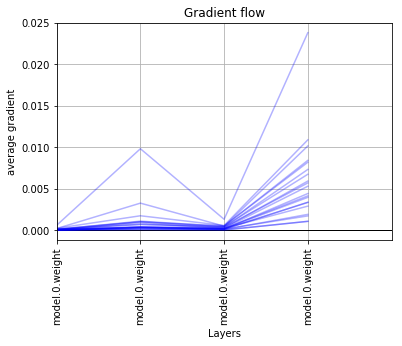

In [62]:
gnn = GNBlock()
optimizer = optim.Adam(gnn.parameters(), lr = 1e-2)

num_props = 1
num_epochs = 20
for epoch in range(num_epochs):
    run_epoch(gnn, optimizer, X, num_props, epoch+1)
plt.show()